In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install wfdb

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

In [8]:
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v4’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-09 15:27:50 (27.3 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v4’ saved [116/116]

--2020-12-09 15:27:50--  https://physionet.org/files/ludb/1.0.0/67.atr_v5
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v5’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-09 15:27:50 (24.6 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v5’ saved [116/116]

--2020-12-09 15:27:50--  https://physionet.org/files/ludb/1.0.0/67.atr_v6
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 110 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v6’

physionet.org/files 100%[=======

# data preprocessing and extracting
- LUDB data
- https://arxiv.org/pdf/2001.04689.pdf

In [9]:
origin_path = '/content/physionet.org/files/ludb/1.0.0'
origin_file = os.listdir(origin_path)
origin_record = pd.read_csv(os.path.join(origin_path,'RECORDS')).values.ravel()

In [10]:
#리드별 파일 추가
cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
for col in cols:
        os.makedirs(col)


In [11]:
#데이터 불러오기

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import re
import wfdb
from wfdb import processing

data_dir = Path('/content/physionet.org/files/ludb/1.0.0')

num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = {'id': i,
            'age(10)' : age //10 * 10, 
            'sex':record.comments[1][-1],
            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'signal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

In [12]:
#리스트로 저장

wave_length = 750
unet_label = list()

for i in range(200):
  unet_label.append(dict())
  for lead in cols:
    unet_label[i][lead] = list()

for i in range(200):
  for lead in cols:
    pqrst_label = np.array(records[i][lead]['anno']) # ann과 동일
    pqrst_point = np.array(records[i][lead]['anno_idx']) # ann_idx
    # lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
    # lead_II = record.p_signal[:,lead_II_idx] #리드2의 전체 signal
    lead_signal = records[i][lead]['signal']

    start_points = np.where(np.array(pqrst_label)=='N')[0]-1 # '('의 인덱스로 리턴

    # qrs파('N')를 시작점으로 모든 segment를 자르자.
    for j,start_point in enumerate(start_points):
        start_index = pqrst_point[start_point]
        seg_signal = lead_signal[start_index:start_index+wave_length] # 첫 qrs부터 750길이의 signal

        pqrst_index = pqrst_point[(pqrst_point>=start_index)&(pqrst_point<start_index+wave_length)] # anno_idx 중에 start_index와 start_index+750 사이에 있는 값들

        # segment 안에 존재하는 pqrst list
        seg_labels = pqrst_label[np.isin(pqrst_point,pqrst_index)] 
        # 해당 pqrst의 segment상 인덱스
        seg_labels_index = pqrst_index - start_index

        unet_label_list = list()
        unet_label_list.append(seg_signal)
        for pqrst in ['p','N','t']:
            # 'p','N','t'의 인덱스
            pqrst_peak = np.where(seg_labels==pqrst)[0]

            # seg_labels에서 onset offset 인덱스

            onset_pqrst = pqrst_peak-1
            offset_pqrst = pqrst_peak+1
 
            mask = np.zeros(wave_length) 
            for onset,offset in zip(onset_pqrst[:],offset_pqrst[:len(onset_pqrst)]):
                try:
                    onset_index = seg_labels_index[onset]
                    offset_index = seg_labels_index[offset]
                    mask[onset_index:offset_index] =1
                except IndexError:
                    pass

            unet_label_list.append(mask)
        
        last_mask = np.ones(wave_length)-(unet_label_list[1]+unet_label_list[2]+unet_label_list[3]) # none of above 마스크
        unet_label_list.append(last_mask)

        unet_label[i][lead].append(unet_label_list)


        # if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
        #     seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
        #     seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
        #     unet_label_list.append(seg_remain)
            
        #     np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))

In [13]:
#p 기준으로 자르는 기존 코드

wave_len = 750
for number,pid in enumerate(origin_record):
    if (number % 10 == 0):
      print('{}/{}'.format(number,len(origin_record)))
    record = wfdb.rdrecord(os.path.join(origin_path,str(pid)))
    atr_ii = wfdb.rdann(os.path.join(origin_path,str(pid)),extension='atr_ii')

    atr_symbols = np.array(atr_ii.symbol)
    atr_points = atr_ii.sample
    l_ii_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
    l_ii = record.p_signal[:,l_ii_idx]

    p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
    #p를 시작점으로 모든 segment를 자르자.
    for idx,p_onset in enumerate(p_onset_list):
        p_idx = atr_points[p_onset]
        l_seg = l_ii[p_idx:p_idx+wave_len] ##df에 들어가

        symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+750)]

        # segments 안에 존재하는 symbol list
        seg_symbols = atr_symbols[np.isin(atr_points,symbols_idx)]
        # 해당 symbol의 seg ECG 상 실제 위치
        seg_symbols_idx = symbols_idx - p_idx

        U_label = list()
        U_label.append(l_seg)
        for symbol in ['p','N','t']:
            # seg_symbol list에서 각 심볼 위치
            label_seg_symbols = np.where(seg_symbols==symbol)[0]

            # seg_symbol list에서 p onset 위치
            on_seg_symbols = label_seg_symbols-1
            off_seg_symbols = label_seg_symbols+1

            dummy = np.zeros(wave_len) #df에 들어가
            for onset,offset in zip(on_seg_symbols,off_seg_symbols[:len(on_seg_symbols)]):
                try:
                    on_idx = seg_symbols_idx[onset]
                    off_idx = seg_symbols_idx[offset]
                    dummy[on_idx:off_idx] =1
                except IndexError:
                    pass
            U_label.append(dummy)
        
        if U_label[-1].sum()!=0: # T가 존재해야지만 저장한다.
            seg_remain = np.logical_or(U_label[1] ,U_label[2])
            seg_remain = (np.logical_or(seg_remain,U_label[3])-1)*(-1)
            U_label.append(seg_remain)
            
            np.save('/content/ii/{}_{}'.format(pid,idx),np.array(U_label))

0/199
10/199
20/199
30/199
40/199
50/199
60/199
70/199
80/199
90/199
100/199
110/199
120/199
130/199
140/199
150/199
160/199
170/199
180/199
190/199


In [14]:
#qrs 기준으로 자르는 코드

wave_len = 750
for number,pid in enumerate(origin_record):
    if (number % 10 == 0):
      print('{}/{}'.format(number,len(origin_record)))
    record = wfdb.rdrecord(os.path.join(origin_path,str(pid)))
    atr_ii = wfdb.rdann(os.path.join(origin_path,str(pid)),extension='atr_ii')

    atr_symbols = np.array(atr_ii.symbol)
    atr_points = atr_ii.sample
    l_ii_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
    l_ii = record.p_signal[:,l_ii_idx]

    N_on_list = np.where(np.array(atr_symbols)=='N')[0]-1
    
    #p를 시작점으로 모든 segment를 자르자.
    for idx,N_onset in enumerate(N_on_list):
        N_idx = atr_points[N_onset]
        l_seg = l_ii[N_idx:N_idx+wave_len] ##df에 들어가

        symbols_idx = atr_points[(atr_points>=N_idx)&(atr_points<N_idx+750)]

        # segments 안에 존재하는 symbol list
        seg_symbols = atr_symbols[np.isin(atr_points,symbols_idx)]
        # 해당 symbol의 seg ECG 상 실제 위치
        seg_symbols_idx = symbols_idx - N_idx

        U_label = list()
        U_label.append(l_seg)
        for symbol in ['p','N','t']:
            # seg_symbol list에서 각 심볼 위치
            symbols_peak = np.where(seg_symbols==symbol)[0]

            # seg_symbol list에서 p onset 위치
            on_seg_symbols = symbols_peak-1
            off_seg_symbols = symbols_peak+1

            dummy = np.zeros(wave_len) #df에 들어가
            for onset,offset in zip(on_seg_symbols,off_seg_symbols[:len(on_seg_symbols)]):
                try:
                    on_idx = seg_symbols_idx[onset]
                    off_idx = seg_symbols_idx[offset]
                    dummy[on_idx:off_idx] =1
                except IndexError:
                    pass
            U_label.append(dummy)
        
        if U_label[-1].sum()!=0: # T가 존재해야지만 저장한다.
            seg_remain = np.logical_or(U_label[1] ,U_label[2])
            seg_remain = (np.logical_or(seg_remain,U_label[3])-1)*(-1)
            U_label.append(seg_remain)
            
            np.save('/content/ii/{}_{}'.format(pid,idx),np.array(U_label))

0/199
10/199
20/199
30/199
40/199
50/199
60/199
70/199
80/199
90/199
100/199
110/199
120/199
130/199
140/199
150/199
160/199
170/199
180/199
190/199


# segment data load

In [15]:
N=10
# N = 10

1637
10


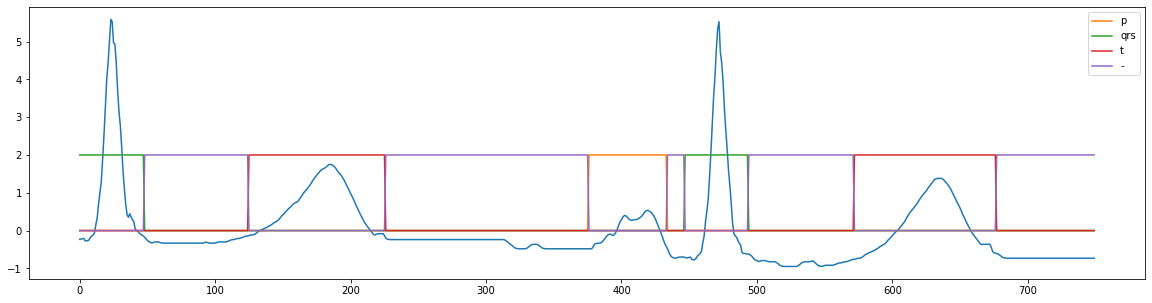

In [16]:
ii_file = os.listdir('/content/ii/')
print(len(ii_file))

ii_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in ii_file],columns=['pid','filename'])
ii_file_df = ii_file_df.sort_values(['pid','filename'])
ii_file_df['filepath'] = ii_file_df.filename.apply(lambda x : os.path.join('/content/ii/',x))
ii_file_df = ii_file_df[ii_file_df.pid!='.ipynb']


seg_ii = np.load(os.path.join('/content/ii/',ii_file_df.filename.tolist()[N]))


plt.figure(figsize=(20, 5))
plt.plot((seg_ii[0]-np.mean(seg_ii[0]))/np.std(seg_ii[0]))
plt.plot((seg_ii[1]*2),label='p')
plt.plot((seg_ii[2]*2),label='qrs')
plt.plot((seg_ii[3]*2),label='t')
plt.plot(seg_ii[4]*2,label='-')
plt.legend()
print(N)
N+=1

# dataset

In [17]:
class seg_data(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
            mask_arr = seg[1:,:]
        except:       
            print(self.filepath[item])
        
        return torch.from_numpy(ecg).unsqueeze(0),torch.from_numpy(mask_arr)
        
        


# model structure

In [18]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [19]:
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

# Train

In [20]:
## hyper parameter
# device = 'cuda:1'
device = 'cuda:0'
class_n = 2
total_epoch = 300

lr = 0.001
batch_size = 256

In [21]:
pid_value = list(set(ii_file_df.pid.tolist()))
shuffle(pid_value)

tr_pid_ii = pid_value[:int(len(pid_value)*(3/4))]
vd_pid_ii = pid_value[int(len(pid_value)*(3/4)):]

tr_file_ii = ii_file_df.query("pid in @tr_pid_ii")
vd_file_ii = ii_file_df.query("pid in @vd_pid_ii")

# tr_file_ii['filepath'] = tr_file_ii['filepath'].map(lambda x: x.replace('../', '/content/data/segments/'))
# vd_file_ii['filepath'] = vd_file_ii['filepath'].map(lambda x: x.replace('../', '/content/data/segments/'))

tr_file_ii['filepath']
vd_file_ii['filepath']

###


tr_data_ii = seg_data(tr_file_ii)
vd_data_ii = seg_data(vd_file_ii)

tr_loader_ii = DataLoader(tr_data_ii,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader_ii = DataLoader(vd_data_ii,batch_size=batch_size)

In [22]:
tr_file_ii

,pid,filename,filepath
1162,100,100_0.npy,/content/ii/100_0.npy
1014,100,100_1.npy,/content/ii/100_1.npy
587,100,100_2.npy,/content/ii/100_2.npy
1409,100,100_3.npy,/content/ii/100_3.npy
1182,100,100_4.npy,/content/ii/100_4.npy
...,...,...,...
715,99,99_5.npy,/content/ii/99_5.npy
1074,99,99_6.npy,/content/ii/99_6.npy
1333,99,99_7.npy,/content/ii/99_7.npy
1060,99,99_8.npy,/content/ii/99_8.npy


In [26]:
tr_file_ii['filepath']

1162    /content/ii/100_0.npy
1014    /content/ii/100_1.npy
587     /content/ii/100_2.npy
1409    /content/ii/100_3.npy
1182    /content/ii/100_4.npy
                ...          
715      /content/ii/99_5.npy
1074     /content/ii/99_6.npy
1333     /content/ii/99_7.npy
1060     /content/ii/99_8.npy
1148     /content/ii/99_9.npy
Name: filepath, Length: 1223, dtype: object

In [28]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [32]:
# tr_output_list = list()
for epoch in range(total_epoch):
    model.train()
    tr_loss_ii = 0
    tr_output_ii = list()

    try:
      for idx,(X,y) in enumerate(tr_loader_ii):
          optim.zero_grad()
          
          y_pred_ii = model(X.to(device))
          loss_ii = loss_f(y_pred_ii,y.to(device))
          
          loss_ii.backward()
          optim.step()
          
          tr_loss_ii+=loss_ii.cpu().item()/len(tr_loader_ii)
          out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
          tr_output_ii.extend(list(out_pred_ii))
          
      print("------------- {} epoch-------------".format(epoch))
      print("Train loss : {:.3f}".format(tr_loss_ii))
    except:
      print("train error")
    
    vd_loss_ii = 0
    try:
      for idx,(X,y) in enumerate(vd_loader_ii):

          y_pred_ii = model(X.to(device))
          out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
          
          loss_ii = loss_f(y_pred_ii,y.to(device))
          vd_loss_ii+=loss_ii.cpu().item()/len(vd_loader_ii)
      print("Valid loss : {:.3f}".format(vd_loss_ii))
    except:
      print("test error")



/content/ii/109_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/188_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/177_10.npy
train error
/content/ii/116_12.npy
test error
/content/ii/177_10.npy
train error
/content/ii/116_12.npy
test error
/content/ii/117_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/57_11.npy
train error
/content/ii/116_12.npy
test error
/content/ii/109_13.npy
train error
/content/ii/116_12.npy
test error
/content/ii/117_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/188_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/58_8.npy
train error
/content/ii/116_12.npy
test error
/content/ii/103_12.npy
train error
/content/ii/116_12.npy
test error
/content/ii/57_11.npy
train error
/content/ii/116_12.npy
test error
/content/ii/177_10.npy
train error
/content/ii/116_12.npy
test error
/content/ii/109_13.npy
train error
/content/ii/116_12.npy
test error
/content/ii/188_12.npy
train error
/co

In [34]:
vd_ecg_ii = list()
vd_label_ii = list()
vd_output_ii = list()

try:
  for idx,(X,y) in enumerate(vd_loader_ii):

      y_pred_ii = model(X.to(device))
      out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
      
      vd_output_ii.extend(list(out_pred_ii))
      vd_ecg_ii.extend(list(X.cpu().detach().numpy().squeeze(1)))
      vd_label_ii.extend(list(y.cpu().detach().numpy()))
except:
  print("test error")

/content/ii/116_12.npy
test error


In [35]:
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

In [36]:
sample_n = np.random.randint(0,len(vd_ecg_ii))
print(sample_n)
ecg_ii = vd_ecg_ii[sample_n]
label = vd_label_ii[sample_n]

ii_out  = vd_output_ii[sample_n]
ii_out  = output_sliding_voting(ii_out ,7)

p = (ii_out  == 0)
N = (ii_out  == 1)
t = (ii_out  == 2)
r = (ii_out  == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True",color='white')
    axes[0].plot(ecg_ii)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg_ii)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")

ValueError: ignored

In [ ]:
### model accuracy 구현 ###

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
total_acc = []

for i in range(len(vd_label_ii)):
  in_ii = [0 for _ in range(600)]
  np.asarray(in_ii)

  label_ii = vd_label_ii[i]

  ii_out   = vd_output_ii[i] ## output
  ii_out   = output_sliding_voting(ii_out  ,7)

  p = (ii_out   == 0)
  N = (ii_out   == 1)
  t = (ii_out   == 2)
  r = (ii_out   == 3)

  for i in range(len(label_ii)):
    in_ii += label_ii[i]*i

  # print(accuracy_score(in_ii, out ))
  total_acc.append(accuracy_score(in_ii, ii_out  ))


print("model accuracy : ", sum(total_acc) / len(total_acc))

model accuracy :  0.9199848024316106


**lead i 기준으로**

In [ ]:
#qrs 기준으로 자르는 코드

wave_len = 600
for number,pid in enumerate(origin_record):
    if (number % 10 == 0):
      print('{}/{}'.format(number,len(origin_record)))
    record = wfdb.rdrecord(os.path.join(origin_path,str(pid)))
    atr_i = wfdb.rdann(os.path.join(origin_path,str(pid)),extension='atr_i')

    atr_symbols = np.array(atr_i.symbol)
    atr_points = atr_i.sample
    l_i_idx = np.where(np.array(record.sig_name)=='i')[0][0]
    l_i = record.p_signal[:,l_i_idx]

    N_on_list = np.where(np.array(atr_symbols)=='N')[0]-1
    
    #p를 시작점으로 모든 segment를 자르자.
    for idx,N_onset in enumerate(N_on_list):
        N_idx = atr_points[N_onset]
        l_seg = l_i[N_idx:N_idx+wave_len] ##df에 들어가

        symbols_idx = atr_points[(atr_points>=N_idx)&(atr_points<N_idx+600)]

        # segments 안에 존재하는 symbol list
        seg_symbols = atr_symbols[np.isin(atr_points,symbols_idx)]
        # 해당 symbol의 seg ECG 상 실제 위치
        seg_symbols_idx = symbols_idx - N_idx

        U_label = list()
        U_label.append(l_seg)
        for symbol in ['p','N','t']:
            # seg_symbol list에서 각 심볼 위치
            symbols_peak = np.where(seg_symbols==symbol)[0]

            # seg_symbol list에서 p onset 위치
            on_seg_symbols = symbols_peak-1
            off_seg_symbols = symbols_peak+1

            dummy = np.zeros(wave_len) #df에 들어가
            for onset,offset in zip(on_seg_symbols,off_seg_symbols[:len(on_seg_symbols)]):
                try:
                    on_idx = seg_symbols_idx[onset]
                    off_idx = seg_symbols_idx[offset]
                    dummy[on_idx:off_idx] =1
                except IndexError:
                    pass
            U_label.append(dummy)
        
        if U_label[-1].sum()!=0: # T가 존재해야지만 저장한다.
            seg_remain = np.logical_or(U_label[1] ,U_label[2])
            seg_remain = (np.logical_or(seg_remain,U_label[3])-1)*(-1)
            U_label.append(seg_remain)
            
            np.save('/content/i/{}_{}'.format(pid,idx),np.array(U_label))

0/199
10/199
20/199
30/199
40/199
50/199
60/199
70/199
80/199
90/199
100/199
110/199
120/199
130/199
140/199
150/199
160/199
170/199
180/199
190/199


1638
10


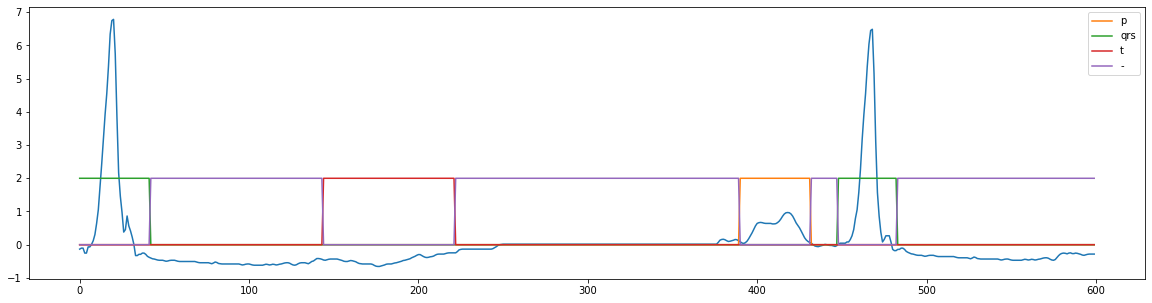

In [ ]:
N=10

i_file = os.listdir('/content/i/')
print(len(i_file))

i_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in i_file],columns=['pid','filename'])
i_file_df = i_file_df.sort_values(['pid','filename'])
i_file_df['filepath'] = i_file_df.filename.apply(lambda x : os.path.join('/content/i/',x))
i_file_df = i_file_df[i_file_df.pid!='.ipynb']


seg_i = np.load(os.path.join('/content/i/',i_file_df.filename.tolist()[N]))


plt.figure(figsize=(20, 5))
plt.plot((seg_i[0]-np.mean(seg_i[0]))/np.std(seg_i[0]))
plt.plot((seg_i[1]*2),label='p')
plt.plot((seg_i[2]*2),label='qrs')
plt.plot((seg_i[3]*2),label='t')
plt.plot(seg_i[4]*2,label='-')
plt.legend()
print(N)
N+=1

In [ ]:
pid_value = list(set(i_file_df.pid.tolist()))
shuffle(pid_value)

tr_pid_i = pid_value[:int(len(pid_value)*(3/4))]
vd_pid_i = pid_value[int(len(pid_value)*(3/4)):]

tr_file_i = i_file_df.query("pid in @tr_pid_i")
vd_file_i = i_file_df.query("pid in @vd_pid_i")

tr_file_i['filepath'] = tr_file_i['filepath'].map(lambda x: x.replace('../', '/content/data/segments/'))
vd_file_i['filepath'] = vd_file_i['filepath'].map(lambda x: x.replace('../', '/content/data/segments/'))

tr_file_i['filepath']
vd_file_i['filepath']

###


tr_data_i = seg_data(tr_file_i)
vd_data_i = seg_data(vd_file_i)

tr_loader_i = DataLoader(tr_data_i,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader_i = DataLoader(vd_data_i,batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# tr_output_list = list()
for epoch in range(total_epoch):
    model.train()
    tr_loss_i = 0
    tr_output_i = list()
    for idx,(X,y) in enumerate(tr_loader_i):
        optim.zero_grad()
        
        y_pred_i = model(X.to(device))
        loss_i = loss_f(y_pred_i,y.to(device))
        
        loss_i.backward()
        optim.step()
        
        tr_loss_i+=loss_i.cpu().item()/len(tr_loader_i)
        out_pred_i = F.softmax(y_pred_i,1).detach().cpu().numpy().argmax(axis=1)
        tr_output_i.extend(list(out_pred_i))
        
    print("------------- {} epoch-------------".format(epoch))
    print("Train loss : {:.3f}".format(tr_loss_i))
    
    vd_loss_i = 0
    for idx,(X,y) in enumerate(vd_loader_i):

        y_pred_i = model(X.to(device))
        out_pred_i = F.softmax(y_pred_i,1).detach().cpu().numpy().argmax(axis=1)
        
        loss_i = loss_f(y_pred_i,y.to(device))
        vd_loss_i+=loss_i.cpu().item()/len(vd_loader_i)
    print("Valid loss : {:.3f}".format(vd_loss_i))



/content/i/58_8.npy


UnboundLocalError: ignored

In [ ]:
vd_ecg_i = list()
vd_label_i = list()
vd_output_i = list()
for idx,(X,y) in enumerate(vd_loader_i):

    y_pred_i = model(X.to(device))
    out_pred_i = F.softmax(y_pred_i,1).detach().cpu().numpy().argmax(axis=1)
    
    vd_output_i.extend(list(out_pred_i))
    vd_ecg_i.extend(list(X.cpu().detach().numpy().squeeze(1)))
    vd_label_i.extend(list(y.cpu().detach().numpy()))

In [ ]:
sample_n = np.random.randint(0,len(vd_ecg_i))
print(sample_n)
ecg_i = vd_ecg_i[sample_n]
label = vd_label_i[sample_n]

i_out  = vd_output_i[sample_n]
i_out  = output_sliding_voting(i_out ,7)

p = (i_out  == 0)
N = (i_out  == 1)
t = (i_out  == 2)
r = (i_out  == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True",color='white')
    axes[0].plot(ecg_i)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg_i)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")

In [ ]:
### model accuracy 구현 ###

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
total_acc = []

for i in range(len(vd_label_ii)):
  in_i = [0 for _ in range(600)]
  np.asarray(in_i)

  label_i = vd_label_i[i]

  i_out   = vd_output_i[i] ## output
  i_out   = output_sliding_voting(i_out  ,7)

  p = (i_out   == 0)
  N = (i_out   == 1)
  t = (i_out   == 2)
  r = (i_out   == 3)

  for i in range(len(label_i)):
    in_i += label_i[i]*i

  # print(accuracy_score(in_ii, out ))
  total_acc.append(accuracy_score(in_i, i_out  ))


print("model accuracy : ", sum(total_acc) / len(total_acc))